In [32]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import time
import collections

In [33]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [34]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_asia = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_alarm = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
df_water = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\Water_1000.dat")
df_ForMed = csv_format_discrete(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\ForMed.dat')
df_andes = csv_format_discrete(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\andes_1000.dat')
# df_large = csv_format_discrete(r"")

In [6]:
df_andes

,DISPLACEM0,RApp1,SNode_3,GIVEN_1,RApp2,SNode_8,SNode_16,SNode_20,NEED1,SNode_21,...,TRY76,GOAL_150,APPLY77,SNode_151,GRAV78,GOAL_153,SNode_155,SNode_14,SNode_18,SNode_19
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,0,1,1,1
3,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,1,1
4,1,1,1,1,1,1,1,0,0,1,...,0,0,1,0,0,0,0,1,1,1
5,1,1,1,1,1,1,1,1,1,0,...,0,0,1,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0,0,1,1,1,1,1,0,0,0,...,1,0,1,0,0,0,0,1,1,1
9997,1,1,1,1,1,1,1,1,1,0,...,0,0,1,1,0,0,0,1,1,1
9998,0,0,1,1,1,1,1,0,0,0,...,1,1,1,1,1,0,0,1,1,1
9999,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1


### chi2 test 0th order

In [7]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### ### Pearson's Product Moment Correlation Coefficient

In [8]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [9]:
#0th order chi2 test
def PMCC(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    R_list = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        R = pearsonr(X=i, Y=j, Z=[], data=df, significance_level=rho)
        R_list.append((i,j,R))
    true_0 = [x for x in R_list if True in x]
    false_0 = [x for x in R_list if False in x]
    return true_0, false_0

### Constraint-based algorithm

In [10]:
def Graph(df):
    G = nx.Graph()
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
#     print(G)
    return(G)

Graph with 223 nodes and 24753 edges


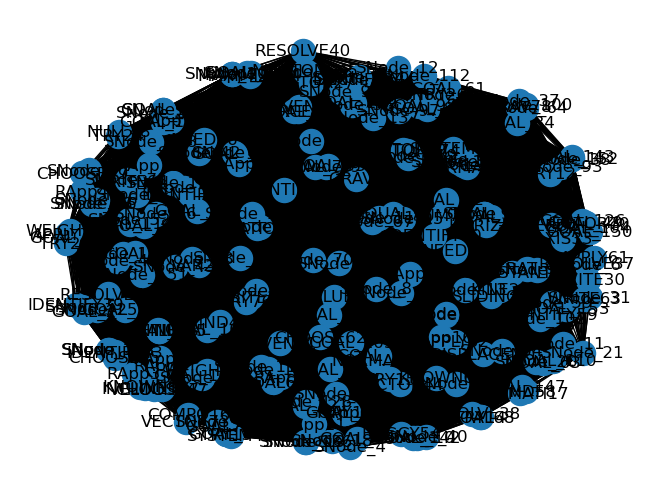

In [11]:
g = Graph(df_andes)
print(g)
nx.draw(g, with_labels = True)

In [12]:
def PC_0(df, rho, G):
    '''
    finds 0th order conditional independencies (CI) between each node, if True then remove an edge 
    '''
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
    ind_0 = [x[:2] for x in chi2bool(df, rho)[0]]
    for i,j in ind_0:
        G.remove_edge(i,j)
    print('the number of edges removed is:' , len(ind_0))
#     print(G)
    return(G, ind_0)

the number of edges removed is: 22164
Graph with 223 nodes and 2589 edges
CPU times: total: 43.3 s
Wall time: 44.8 s


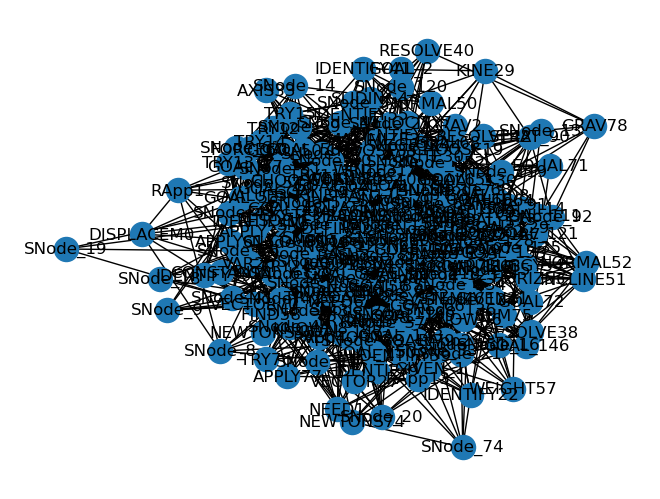

In [14]:
%%time
g_0 = PC_0(df_andes, 0.05, g)[0]
print(g_0)
nx.draw(g_0, with_labels = True)

In [15]:
def find_adjacency_XY(graph):    
    '''
    finds adjacencies of XY in the graph
    Input: a graph from networkx
    Returns: a list containing (X,Y, [XY_adjacents]) where X and Y are connected by an edge and XY_adjacents are its adjacents
    '''
    test_list = []
    graph_list = list(graph.edges)
    for i,j in graph_list:
        test_list.append((i, j, list(graph.edges(i)), list(graph.edges(j))))
    n = 0
    N = len(test_list)
    edge_XY = []
    while n < N:
        ##
        adjacent_X = []
        adjacent_Y = []
        X, Y = test_list[n][0], test_list[n][1]
        k_X, k_Y = test_list[n][2], test_list[n][3]
        edge_X = [x for x in k_X if x[1] != Y]
        edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
        for x in edge_X:
            adjacent_X.append(x[1])
        for y in edge_Y:
            adjacent_Y.append(y[1])
        adjacent_XY = adjacent_X + adjacent_Y
        len_XY = len(adjacent_XY)
        edge_XY.append((X, Y, adjacent_XY, len_XY))
#         print(edge_XY)
        n += 1
    return edge_XY

In [16]:
adj = find_adjacency_XY(g_0)

In [17]:
def get_combinations(this_list, df, N_0, rho):
    '''
    this_list = one of the items in adj, eg: adj[1]
    probably the main function of everything
    given a list in the form
    '''
    adjacency = this_list[2]
    len_adjacency = len(adjacency)
    n = 1
    combinations = []
    while n <= N_0:
        k = list(itertools.combinations(adjacency, n))
        t = [list(x) for x in k]
#         return(k)
#         return(t)
        for i in t:
            chi2 = chi_square(X=this_list[0], Y=this_list[1], Z=i, data=df, significance_level=rho)
            if chi2 == True:
                combinations.append((this_list[0], this_list[1], i, chi2))
                print(combinations)
                return combinations
        n += 1

In [18]:
adj[2]

('DISPLACEM0',
 'GOAL_49',
 ['RApp1',
  'SNode_8',
  'SNode_17',
  'GOAL_61',
  'GOAL_63',
  'SNode_65',
  'FIND58',
  'GRAV2',
  'GOAL_48',
  'COMPO16',
  'TRY12',
  'TRY11',
  'SNode_5',
  'SNode_6',
  'GOAL_50',
  'SNode_51',
  'SNode_52',
  'KINEMATI17',
  'GOAL_53',
  'SNode_28',
  'TRY13',
  'TRY14',
  'TRY15',
  'GOAL_56',
  'GOAL_57',
  'SNode_54',
  'GOAL_69',
  'SNode_55',
  'GOAL_72',
  'RApp6',
  'GOAL_81',
  'GOAL_83',
  'GOAL_84',
  'SNode_86',
  'GOAL_103',
  'SNode_132',
  'RApp11',
  'RApp12',
  'GOAL_147',
  'SNode_14'],
 40)

In [20]:
get_combinations(adj[4], df_andes, 3, 0.05)

[('DISPLACEM0', 'GOAL_61', ['RApp1'], True)]


[('DISPLACEM0', 'GOAL_61', ['RApp1'], True)]

In [21]:
def combinations_adjacents(adj, df, N, rho):
    '''
    one of the main functions
    adj = output from find_adjacency_XY
    N = stopping point for how many combinations you want
    output: obtains the combinations of n=1,2,...N of the whole list in an unordered manner (see open_list)
    '''
    len_adjacents = len(adj)
    combinations = []
    for i in range(len_adjacents):
        t = get_combinations(adj[i], df, N, rho)
        combinations.append(t)
    return combinations

In [22]:
def PC_final(graph, adj, N, df, rho):
    '''
    graph = nx.graph
    adj = output from find_adjacency_XY
    N = order of conditional independence
    df = dataframe
    rho = significance_level
    '''
    X_Y = []
    combinations_chi2 = combinations_adjacents(adj, df, N, rho)
    for i in combinations_chi2:
        if i != None:
            for j in i:
                X_Y.append((j[0], j[1]))
    for i in X_Y:
        graph.remove_edge(i[0], i[1])
    return graph, X_Y

In [23]:
%%time
g_final = PC_final(g_0, adj, 1, df_andes, 0.05)

[('DISPLACEM0', 'SNode_8', ['RApp1'], True)]
[('DISPLACEM0', 'GOAL_49', ['RApp1'], True)]
[('DISPLACEM0', 'SNode_17', ['RApp1'], True)]
[('DISPLACEM0', 'GOAL_61', ['RApp1'], True)]
[('DISPLACEM0', 'GOAL_63', ['RApp1'], True)]
[('DISPLACEM0', 'SNode_65', ['RApp1'], True)]
[('DISPLACEM0', 'FIND58', ['RApp1'], True)]
[('RApp1', 'SNode_47', ['SNode_3'], True)]
[('RApp1', 'GOAL_49', ['DISPLACEM0'], True)]
[('RApp1', 'SNode_17', ['DISPLACEM0'], True)]
[('RApp1', 'GOAL_61', ['DISPLACEM0'], True)]
[('RApp1', 'GOAL_63', ['DISPLACEM0'], True)]
[('RApp1', 'FIND58', ['DISPLACEM0'], True)]
[('SNode_3', 'GRAV2', ['SNode_47'], True)]
[('SNode_3', 'RApp3', ['SNode_47'], True)]
[('SNode_3', 'GOAL_2', ['GOAL_48'], True)]
[('SNode_3', 'SYSTEM46', ['SNode_86'], True)]
[('SNode_3', 'SNode_100', ['GRAV2'], True)]
[('SNode_3', 'SNode_102', ['GRAV2'], True)]
[('SNode_3', 'CHOOSE62', ['SNode_47'], True)]
[('SNode_3', 'GOAL_150', ['GRAV2'], True)]
[('GIVEN_1', 'SNode_8', ['RApp2'], True)]
[('GIVEN_1', 'COMPO16'

[('CONSTANT5', 'SNode_42', ['SNode_41'], True)]
[('CONSTANT5', 'SNode_43', ['SNode_26'], True)]
[('CONSTANT5', 'SNode_55', ['SNode_34'], True)]
[('CONSTANT5', 'GOAL_84', ['SNode_26'], True)]
[('CONSTANT5', 'SNode_100', ['SNode_26'], True)]
[('CONSTANT5', 'SNode_122', ['SNode_26'], True)]
[('SNode_47', 'KNOWN6', ['RApp1'], True)]
[('SNode_47', 'SNode_27', ['RApp3'], True)]
[('SNode_47', 'SNode_6', ['RApp1'], True)]
[('SNode_47', 'GOAL_50', ['VELOCITY7'], True)]
[('SNode_47', 'CHOOSE19', ['VELOCITY7'], True)]
[('SNode_47', 'SNode_51', ['VELOCITY7'], True)]
[('SNode_47', 'SNode_55', ['VELOCITY7'], True)]
[('SNode_47', 'RESOLVE42', ['RApp1'], True)]
[('SNode_47', 'SNode_68', ['RApp1'], True)]
[('SNode_47', 'GOAL68', ['SNode_3'], True)]
[('VELOCITY7', 'RApp3', ['SNode_47'], True)]
[('VELOCITY7', 'SNode_27', ['SNode_47'], True)]
[('VELOCITY7', 'GOAL_50', ['SNode_47'], True)]
[('VELOCITY7', 'SNode_17', ['SNode_47'], True)]
[('VELOCITY7', 'SNode_51', ['SNode_47'], True)]
[('VELOCITY7', 'GIVEN2

[('TRY11', 'IDENTIFY59', ['SNode_25'], True)]
[('TRY11', 'FORCE60', ['SNode_27'], True)]
[('TRY11', 'GOAL_103', ['SNode_25'], True)]
[('TRY11', 'SNode_123', ['TRY14'], True)]
[('TRY11', 'RApp10', ['SNode_25'], True)]
[('SNode_5', 'GOAL_50', ['GOAL_49'], True)]
[('SNode_5', 'TRY15', ['RApp5'], True)]
[('SNode_5', 'RApp5', ['GOAL_49'], True)]
[('SNode_5', 'SNode_152', ['GOAL_49'], True)]
[('SNode_5', 'GOAL66', ['GOAL_49'], True)]
[('SNode_5', 'GOAL68', ['GOAL_50'], True)]
[('SNode_5', 'SNode_134', ['GOAL_49'], True)]
[('SNode_5', 'RApp11', ['RApp5'], True)]
[('GOAL_49', 'SNode_51', ['GOAL_50'], True)]
[('GOAL_49', 'SNode_52', ['GOAL_50'], True)]
[('GOAL_49', 'KINEMATI17', ['GRAV2'], True)]
[('GOAL_49', 'SNode_28', ['GOAL_53'], True)]
[('GOAL_49', 'TRY13', ['TRY12'], True)]
[('GOAL_49', 'TRY14', ['TRY12'], True)]
[('GOAL_49', 'TRY15', ['TRY12'], True)]
[('GOAL_49', 'GOAL_57', ['GOAL_56'], True)]
[('GOAL_49', 'GOAL_61', ['GRAV2'], True)]
[('GOAL_49', 'SNode_54', ['GOAL_53'], True)]
[('GOAL

[('IDENTIFY9', 'SNode_31', ['SNode_28'], True)]
[('IDENTIFY9', 'GOAL_63', ['GIVEN_1'], True)]
[('IDENTIFY9', 'GOAL_98', ['SNode_28'], True)]
[('IDENTIFY9', 'GOAL_87', ['GIVEN_1'], True)]
[('IDENTIFY9', 'SNode_88', ['GIVEN_1'], True)]
[('IDENTIFY9', 'GOAL_99', ['SNode_28'], True)]
[('IDENTIFY9', 'RApp9', ['GIVEN_1'], True)]
[('IDENTIFY9', 'SNode_128', ['GIVEN_1'], True)]
[('IDENTIFY9', 'SNode_155', ['SNode_28'], True)]
[('TRY13', 'TRY14', ['TRY12'], True)]
[('TRY13', 'TRY15', ['TRY12'], True)]
[('TRY13', 'VAR20', ['SNode_25'], True)]
[('TRY13', 'GOAL_56', ['TRY12'], True)]
[('TRY13', 'NEWTONS45', ['SNode_25'], True)]
[('TRY13', 'DEFINE23', ['SNode_25'], True)]
[('TRY13', 'SNode_71', ['TRY12'], True)]
[('TRY13', 'WEIGHT56', ['TRY12'], True)]
[('TRY13', 'FIND58', ['SNode_25'], True)]
[('TRY13', 'SNode_14', ['TRY12'], True)]
[('TRY14', 'TRY15', ['TRY12'], True)]
[('TRY14', 'SNode_29', ['SNode_25'], True)]
[('TRY14', 'SNode_10', ['TRY12'], True)]
[('TRY14', 'GOAL_56', ['TRY12'], True)]
[('T

[('MAXIMIZE34', 'SNode_152', ['SNode_106'], True)]
[('MAXIMIZE34', 'GOAL_107', ['SNode_152'], True)]
[('MAXIMIZE34', 'GOAL_108', ['SNode_106'], True)]
[('MAXIMIZE34', 'RApp9', ['SNode_24'], True)]
[('MAXIMIZE34', 'GOAL_130', ['SNode_24'], True)]
[('MAXIMIZE34', 'SNode_137', ['SNode_24'], True)]
[('SNode_60', 'GOAL_62', ['GOAL_61'], True)]
[('SNode_60', 'CHOOSE47', ['SNode_26'], True)]
[('SNode_60', 'SNode_46', ['SNode_26'], True)]
[('SNode_60', 'SNode_12', ['SNode_26'], True)]
[('SNode_60', 'SNode_106', ['SNode_59'], True)]
[('SNode_60', 'RApp7', ['RApp3'], True)]
[('SNode_60', 'SNode_125', ['SNode_59'], True)]
[('SNode_60', 'SNode_154', ['SNode_26'], True)]
[('SNode_60', 'SNode_136', ['RApp3'], True)]
[('SNode_60', 'RApp12', ['RApp3'], True)]
[('AXIS33', 'GOAL_61', ['SNode_60'], True)]
[('AXIS33', 'GOAL_62', ['SNode_60'], True)]
[('AXIS33', 'SNode_67', ['SNode_60'], True)]
[('AXIS33', 'GOAL_69', ['SNode_60'], True)]
[('AXIS33', 'GOAL_83', ['SNode_60'], True)]
[('GOAL_61', 'GOAL_63', [

[('SNode_67', 'SNode_71', ['SNode_15'], True)]
[('SNode_67', 'SNode_94', ['SNode_31'], True)]
[('SNode_67', 'WEIGHT56', ['SNode_31'], True)]
[('SNode_67', 'GOAL66', ['NEED36'], True)]
[('SNode_67', 'RApp8', ['NEED36'], True)]
[('SNode_67', 'SNode_112', ['SNode_68'], True)]
[('SNode_67', 'SNode_115', ['NEED36'], True)]
[('SNode_67', 'SNode_116', ['SNode_15'], True)]
[('SNode_67', 'SNode_117', ['NEED36'], True)]
[('SNode_67', 'RApp9', ['SNode_15'], True)]
[('SNode_67', 'RApp10', ['NEED36'], True)]
[('SNode_67', 'SNode_131', ['NEED36'], True)]
[('SNode_67', 'SNode_133', ['NEED36'], True)]
[('SNode_67', 'SNode_154', ['NEED36'], True)]
[('SNode_67', 'GOAL_146', ['SNode_31'], True)]
[('SNode_54', 'SNode_70', ['GOAL_69'], True)]
[('SNode_54', 'SNode_55', ['GOAL_53'], True)]
[('SNode_54', 'GOAL_72', ['GOAL_48'], True)]
[('SNode_54', 'SNode_44', ['GOAL_53'], True)]
[('SNode_54', 'SNode_46', ['GOAL_53'], True)]
[('SNode_54', 'SNode_65', ['SNode_52'], True)]
[('SNode_54', 'SNode_71', ['GOAL_53'],

[('EQUATION28', 'HORIZ53', ['GOAL_48'], True)]
[('EQUATION28', 'CHOOSE62', ['GOAL_48'], True)]
[('EQUATION28', 'GOAL_107', ['IDENTIFY39'], True)]
[('EQUATION28', 'WRITE64', ['GOAL_109'], True)]
[('EQUATION28', 'GOAL_109', ['GOAL_107'], True)]
[('EQUATION28', 'RApp7', ['GOAL_48'], True)]
[('EQUATION28', 'GOAL_127', ['GOAL_80'], True)]
[('EQUATION28', 'RApp11', ['GOAL_142'], True)]
[('VECTOR27', 'GOAL_81', ['RApp5'], True)]
[('VECTOR27', 'GOAL_83', ['RApp5'], True)]
[('VECTOR27', 'GOAL_84', ['RApp5'], True)]
[('VECTOR27', 'GOAL_98', ['RESOLVE38'], True)]
[('VECTOR27', 'SNode_88', ['RESOLVE38'], True)]
[('VECTOR27', 'NEED67', ['RESOLVE38'], True)]
[('VECTOR27', 'GOAL_149', ['GOAL_147'], True)]
[('RApp5', 'GOAL_83', ['GOAL_81'], True)]
[('RApp5', 'GOAL_84', ['GOAL_81'], True)]
[('RApp5', 'SNode_86', ['GOAL_81'], True)]
[('RApp5', 'SNode_156', ['SNode_5'], True)]
[('RApp5', 'DEFINE23', ['SNode_74'], True)]
[('RApp5', 'SNode_37', ['GOAL_81'], True)]
[('RApp5', 'GOAL_87', ['SNode_5'], True)]


[('NEWTONS45', 'SNode_40', ['SNode_24'], True)]
[('NEWTONS45', 'GOAL_87', ['SNode_156'], True)]
[('NEWTONS45', 'SNode_88', ['SNode_24'], True)]
[('NEWTONS45', 'SNode_95', ['SNode_24'], True)]
[('NEWTONS45', 'SNode_100', ['SNode_156'], True)]
[('NEWTONS45', 'GOAL_126', ['SNode_24'], True)]
[('GOAL_98', 'SNode_38', ['SNode_37'], True)]
[('GOAL_98', 'SNode_40', ['SNode_38'], True)]
[('GOAL_98', 'SNode_88', ['GOAL_87'], True)]
[('GOAL_98', 'SNode_93', ['SNode_28'], True)]
[('GOAL_98', 'SNode_94', ['GOAL_87'], True)]
[('GOAL_98', 'SNode_95', ['SNode_156'], True)]
[('GOAL_98', 'SNode_97', ['GOAL_87'], True)]
[('GOAL_98', 'SNode_102', ['GOAL_87'], True)]
[('GOAL_98', 'GOAL_103', ['SNode_10'], True)]
[('GOAL_98', 'VECTOR70', ['RApp3'], True)]
[('GOAL_98', 'SNode_123', ['SNode_100'], True)]
[('GOAL_98', 'SNode_124', ['SNode_37'], True)]
[('GOAL_98', 'GOAL_150', ['SNode_37'], True)]
[('GOAL_98', 'SNode_151', ['SNode_37'], True)]
[('GOAL_98', 'SNode_155', ['RApp3'], True)]
[('DEFINE23', 'SNode_37

[('SNode_91', 'SNode_94', ['GOAL_87'], True)]
[('SNode_91', 'SNode_95', ['GOAL_87'], True)]
[('SNode_91', 'SNode_97', ['SNode_88'], True)]
[('SNode_91', 'SNode_102', ['SNode_88'], True)]
[('SNode_91', 'CHOOSE62', ['SLIDING4'], True)]
[('SNode_91', 'WRITE64', ['KNOWN6'], True)]
[('SNode_91', 'SNode_136', ['SNode_25'], True)]
[('SNode_91', 'SNode_155', ['SNode_25'], True)]
[('SNode_12', 'SNode_95', ['SNode_60'], True)]
[('SNode_12', 'GOAL66', ['APPLY32'], True)]
[('SNode_12', 'GOAL_130', ['APPLY32'], True)]
[('SNode_12', 'SNode_136', ['APPLY32'], True)]
[('SNode_12', 'TRY76', ['APPLY32'], True)]
[('SNode_13', 'BUGGY54', ['RESOLVE42'], True)]
[('SNode_13', 'GOAL66', ['CHOOSE35'], True)]
[('SNode_13', 'GOAL_130', ['CHOOSE35'], True)]
[('SNode_13', 'SNode_134', ['CHOOSE35'], True)]
[('STRAT_90', 'SNode_135', ['WRITE31'], True)]
[('HORIZ53', 'BUGGY54', ['NORMAL52'], True)]
[('HORIZ53', 'SNode_92', ['NORMAL52'], True)]
[('HORIZ53', 'SNode_97', ['SNode_21'], True)]
[('HORIZ53', 'RApp8', ['SNod

[('GOAL_107', 'GOAL_127', ['GOAL_108'], True)]
[('GOAL_107', 'RApp9', ['GOAL_108'], True)]
[('GOAL_107', 'RApp10', ['GOAL_108'], True)]
[('GOAL_107', 'GOAL_129', ['GOAL_108'], True)]
[('GOAL_107', 'GOAL_130', ['GOAL_108'], True)]
[('GOAL_107', 'SNode_154', ['GOAL_109'], True)]
[('GOAL_107', 'SNode_136', ['GOAL_108'], True)]
[('GOAL_107', 'SNode_137', ['GOAL_108'], True)]
[('GOAL_107', 'GOAL_153', ['GOAL_108'], True)]
[('GOAL_107', 'SNode_155', ['GOAL_108'], True)]
[('WRITE63', 'GOAL_108', ['GOAL_107'], True)]
[('WRITE63', 'GOAL_109', ['GOAL_107'], True)]
[('WRITE63', 'RApp7', ['GOAL_107'], True)]
[('WRITE63', 'SNode_112', ['GOAL_107'], True)]
[('WRITE63', 'GOAL_121', ['GOAL_107'], True)]
[('WRITE63', 'SNode_125', ['GOAL_107'], True)]
[('WRITE63', 'RApp9', ['GOAL_108'], True)]
[('WRITE63', 'SNode_128', ['GOAL_107'], True)]
[('WRITE63', 'SNode_137', ['GOAL_107'], True)]
[('WRITE63', 'RApp12', ['GIVEN_1'], True)]
[('GOAL_108', 'GOAL_110', ['GOAL_109'], True)]
[('GOAL_108', 'GOAL65', ['GOA

[('SNode_112', 'VECTOR70', ['NEED67'], True)]
[('SNode_112', 'SNode_119', ['TRY14'], True)]
[('SNode_112', 'GOAL_121', ['GOAL_109'], True)]
[('SNode_112', 'GOAL_126', ['GOAL_108'], True)]
[('SNode_112', 'RApp9', ['RApp7'], True)]
[('SNode_112', 'SNode_131', ['NEED36'], True)]
[('SNode_112', 'SNode_133', ['NEED36'], True)]
[('SNode_112', 'GOAL_142', ['RApp7'], True)]
[('SNode_112', 'RApp11', ['RApp7'], True)]
[('SNode_112', 'GOAL_153', ['GOAL_108'], True)]
[('GOAL_113', 'SNode_115', ['GOAL_114'], True)]
[('GOAL_113', 'SNode_119', ['SNode_117'], True)]
[('GOAL_113', 'GOAL_121', ['GOAL_109'], True)]
[('GOAL_113', 'SNode_122', ['CHOOSE35'], True)]
[('GOAL_113', 'SNode_125', ['GOAL_109'], True)]
[('GOAL_113', 'GOAL_126', ['GOAL_110'], True)]
[('GOAL_113', 'RApp9', ['GOAL_108'], True)]
[('GOAL_113', 'SNode_128', ['CHOOSE35'], True)]
[('GOAL_113', 'SNode_131', ['GOAL_130'], True)]
[('GOAL_113', 'SNode_154', ['CHOOSE35'], True)]
[('GOAL_113', 'SNode_137', ['CHOOSE35'], True)]
[('GOAL_113', 'GO

[('GOAL_130', 'SNode_137', ['GOAL_108'], True)]
[('GOAL_130', 'GOAL_153', ['GOAL_108'], True)]
[('SNode_131', 'SNode_154', ['NEED36'], True)]
[('SNode_131', 'GOAL_149', ['KNOWN8'], True)]
[('SNode_132', 'SNode_133', ['SNode_8'], True)]
[('SNode_132', 'SNode_135', ['SNode_8'], True)]
[('SNode_132', 'RApp13', ['GOAL_146'], True)]
[('SNode_133', 'SNode_154', ['NEED36'], True)]
[('SNode_133', 'SNode_137', ['SNode_27'], True)]
[('SNode_133', 'GOAL_146', ['NEED36'], True)]
[('SNode_133', 'RApp13', ['NEED36'], True)]
[('SNode_133', 'GOAL_147', ['SNode_64'], True)]
[('SNode_133', 'GOAL_149', ['GOAL_129'], True)]
[('SNode_133', 'GOAL_150', ['SNode_27'], True)]
[('SNode_133', 'GOAL_153', ['SNode_27'], True)]
[('SNode_134', 'GOAL_150', ['GIVEN_1'], True)]
[('SNode_154', 'SNode_136', ['GOAL_121'], True)]
[('SNode_154', 'SNode_137', ['GOAL_109'], True)]
[('SNode_154', 'RApp11', ['SNode_59'], True)]
[('SNode_154', 'GOAL_153', ['GOAL_121'], True)]
[('SNode_136', 'SNode_137', ['GOAL_107'], True)]
[('S

Graph with 223 nodes and 540 edges


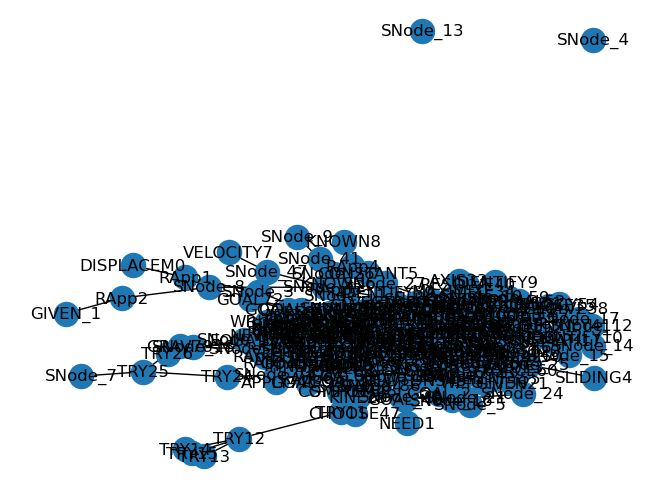

In [24]:
print(g_final[0])
nx.draw(g_final[0], with_labels=True)


In [26]:
ind = g_final[1] + chi2bool(df_andes, 0.05)[0]

In [28]:
ind

[('PCLRfacet3', 'BPD'),
 ('PCLRfacet3', 'AbuseNeglectAsChild'),
 ('PCLRfacet3', 'PCLRfactor2'),
 ('PCLRfacet3', 'prioracq'),
 ('PCLRfacet3', 'Age'),
 ('PCLRfacet3', 'pclrscore'),
 ('PCLRfacet3', 'EcstasyAfterRelease'),
 ('PCLRfacet3', 'AlcoholDependence'),
 ('PCLRfacet3', 'SubstanceMisuseDL'),
 ('PCLRfacet3', 'Violence'),
 ('PCLRfacet3', 'ViolentConvictions'),
 ('PCLRfacet3', 'Anger'),
 ('PCLRfacet3', 'AngerPT'),
 ('PCLRfacet3', 'AggressionDL'),
 ('PCLRfacet3', 'ViolentConvictionsRate'),
 ('PCLRfacet3', 'ViolentConvRateGivenProt'),
 ('PCLRfacet3', 'Depression'),
 ('PCLRfacet3', 'PsychiatricTreatment'),
 ('PCLRfacet3', 'PsychiatricTreatmentGivenRFAT'),
 ('AbilityToCope', 'prioracq'),
 ('AbilityToCope', 'pclrscore'),
 ('AbilityToCope', 'Education'),
 ('AbilityToCope', 'EmploymentOrTraining'),
 ('AbilityToCope', 'CannabisBeforePrisonSentence'),
 ('AbilityToCope', 'CannabisDuringPrisonSentence'),
 ('AbilityToCope', 'ResponsivenessToTreatment'),
 ('AbilityToCope', 'ResponseToTreatGivenAlcDe

In [31]:
for i in ind:
    print(i[0], i[1])

PCLRfacet3 BPD
PCLRfacet3 AbuseNeglectAsChild
PCLRfacet3 PCLRfactor2
PCLRfacet3 prioracq
PCLRfacet3 Age
PCLRfacet3 pclrscore
PCLRfacet3 EcstasyAfterRelease
PCLRfacet3 AlcoholDependence
PCLRfacet3 SubstanceMisuseDL
PCLRfacet3 Violence
PCLRfacet3 ViolentConvictions
PCLRfacet3 Anger
PCLRfacet3 AngerPT
PCLRfacet3 AggressionDL
PCLRfacet3 ViolentConvictionsRate
PCLRfacet3 ViolentConvRateGivenProt
PCLRfacet3 Depression
PCLRfacet3 PsychiatricTreatment
PCLRfacet3 PsychiatricTreatmentGivenRFAT
AbilityToCope prioracq
AbilityToCope pclrscore
AbilityToCope Education
AbilityToCope EmploymentOrTraining
AbilityToCope CannabisBeforePrisonSentence
AbilityToCope CannabisDuringPrisonSentence
AbilityToCope ResponsivenessToTreatment
AbilityToCope ResponseToTreatGivenAlcDep
AbilityToCope ResponseToTreatGivenDrugDep
AbilityToCope PsychiatricTreatmentGivenRFAT
Stress Victimisation
Stress AbuseNeglectAsChild
Stress PCLRfactor2
Stress CriminalNetwork
Stress Intelligence
Stress SymptomsOfMentalIllness
Stress Cann

In [27]:
m = Gobnilp()
for i in ind:
    m.add_forbidden_adjacency((i[0], i[1]))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-21
Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


**********
BN has score -933658.2367691786
**********
APPLY32<- -6935.761982390628
APPLY61<- -6935.879586169351
APPLY77<- -6936.278592118644
AXIS33<- -4913.129702094564
BUGGY54<-INCLINE51,NORMAL52 -3210.288454063135
INCLINE51<-HORIZ53 -2836.2254543230956
NORMAL52<-HORIZ53,INCLINE51 -5.181059206632199
CHOOSE19<- -6936.134591195587
CHOOSE35<- -6936.302792138085
CHOOSE47<- -6935.915587141761
CHOOSE62<- -6935.9499879902
COMPO16<- -6935.9499879902
CONSTANT5<- -6936.12279105866
DEFINE23<- -6935.9499879902
DISPLACEM0<- -6936.301992138062
EQUAL71<- -6747.317038146895
EQUATION28<- -6713.299312343006
FIND49<- -6935.377963630555
FIND58<-NEWTONS74 -6164.498748411046
NEWTONS74<-SNode_124 -6932.78975834453
FORCE60<- -4966.984087426463
GIVEN21<- -3295.031743080661
GIVEN_1<- -1008.4822806059383
GOAL65<- -6933.926403899328
GOAL66<- -6753.544901633984
GOAL68<- -6935.740981618845
GOAL72<- -6935.55857367834
GOAL_103<-APPLY61,GOAL_83,SNode_102 -4763.367126422716
SNode_102<-FORCE60,SNode_88,SNode_94 -3166.2

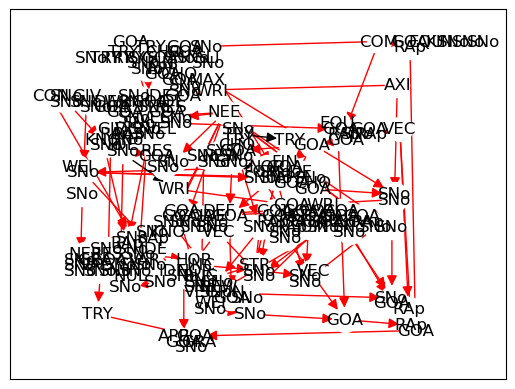

CPU times: total: 1min 10s
Wall time: 59.3 s


In [31]:
%%time
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\andes_1000.dat')
#runtime unfeasible

In [ ]:
tic = time.time()
g = Gobnilp()
g.learn(r'FORMED_final_0.dat')
toc = time.time()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-21
Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
